In [1]:
import pandas as pd
import glob, os, re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import matplotlib.dates as mdates
from matplotlib import cm, ticker
from scipy.signal import savgol_filter

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_temp(path, begintime, endtime, type='CWA'):
    
    def get_strtime(time):
        yyyy = str(time.year)
        mm   = str(time.month).zfill(2)
        dd   = str(time.day).zfill(2)
        hh   = str(time.hour).zfill(2)
        return f'{yyyy}{mm}{dd}{hh}00'
    
    if type == 'CWA':
        df = pd.read_csv(path, skiprows=9)
        begin = get_strtime(begintime); end = get_strtime(endtime)
        df_ = df[df['yyyymmddhhmi'] >= int(begin)][df['yyyymmddhhmi'] <= int(end)]
        list = []
        for i in range(len(df_)):
            timestr = str(df_['yyyymmddhhmi'].values[i])
            yyyy = int(timestr[:4])
            mm  = int(timestr[4:6])
            dd = int(timestr[6:8])
            hh = int(timestr[8:10])
            minn  = int(timestr[10:])
            list.append(datetime(yyyy,mm,dd,hh,minn))
        newdf = pd.DataFrame({'time':list,
                              'temp':df_['T']} ) 
    elif type == 'hobo':
        newdf = pd.read_excel(path, header=None, names=['time', 'temp', 'Light'], skiprows=110, skipfooter=100)
        print(newdf)
    return newdf

def find_color_symbol(begintime):
    year = begintime.year
    month = begintime.month
    if year == 2021:
        c = 'blue'
    elif year == 2022:
        c = 'lightblue'
    elif year == 2023:
        c = 'purple'
        
    if month < 6:
        m = 'o'
    elif 6 <= month <9:
        m = 's'
    elif 9<=month < 11:
        m = 'D'
    else:
        m = 'X'
    return c, m 

### temperature

210519-210606
210701-210718
210823-210910
220423-220512
220627-220716
220808-220824
230417-230505
230609-230625
                     time       temp     Light
110   2023-06-09 11:43:15  25.951963   5800.96
111   2023-06-09 11:44:15  25.951963   4994.56
112   2023-06-09 11:45:15  25.866162   2129.28
113   2023-06-09 11:46:15  25.565859   1765.12
114   2023-06-09 11:47:15  25.179756   2231.68
...                   ...        ...       ...
25874 2023-06-27 09:07:15  28.225684  10992.64
25875 2023-06-27 09:08:15  28.268584  10150.40
25876 2023-06-27 09:09:15  28.268584  11217.92
25877 2023-06-27 09:10:15  28.311484  10526.72
25878 2023-06-27 09:11:15  28.268584  10808.32

[25769 rows x 3 columns]
230829-230915
                     time       temp    Light
110   2023-08-29 10:45:57  29.255293   303.12
111   2023-08-29 10:46:57  29.169492   358.72
112   2023-08-29 10:47:57  29.126592   144.08
113   2023-08-29 10:48:57  29.040791   141.72
114   2023-08-29 10:49:57  28.997891   208.88
...     

Text(0.5, 1.0, 'Keelung')

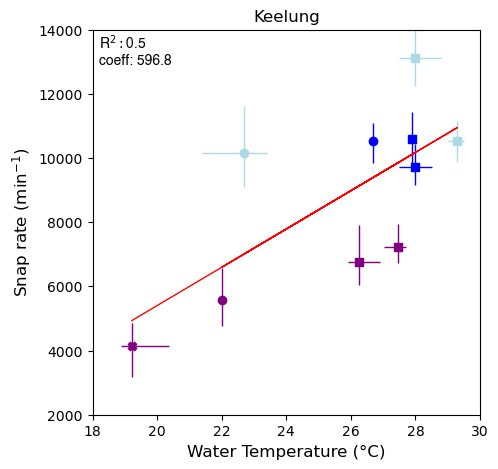

In [3]:
place = 'Keelung'
path = f'/Volumes/home/Research/Detection_snap/{place}'

fig, ax = plt.subplots(1, figsize=(5, 5), sharex=True)
plt.rcParams["font.family"] =  "Helvetica"  

x = []; y = []
for ii, dirpath in enumerate(sorted(glob.glob(f'{path}/??????-??????'))):
    alldf = pd.DataFrame()
    begin = re.split('[/|-]', dirpath)[-2]
    end = re.split('[/|-]', dirpath)[-1]
    begintime = datetime.strptime(begin, "%y%m%d"); endtime = datetime.strptime(end, "%y%m%d")
    print(f'{begin}-{end}')
    
    for file in glob.glob(f'{dirpath}/*csv'):
        df = pd.read_csv(file)
        alldf = pd.concat([alldf, df])
    Q1_peak = np.percentile(alldf['Peak'], 25)
    median_peak = np.median(alldf['Peak'])
    mean_peak = np.mean(alldf['Peak'])
    Q3_peak = np.percentile(alldf['Peak'], 75)
    
    try:
        temppath = glob.glob(f'../DataBase/Temperature/{place}/{begin[:4]}*.xlsx')[0]
        newdf = read_temp(temppath, begintime, endtime ,type='hobo')
    except:     
        tempplace = '長潭里'  if place == 'Keelung' else '竹圍' 
        temppath = glob.glob(f'../DataBase/Data_CWA/{begintime.year}_*{tempplace}*_stemp.csv')[0]
        newdf = read_temp(temppath, begintime, endtime ,type='CWA')
        
    Q3_temp = np.percentile(newdf['temp'], 75)
    median_temp = np.nanmedian(newdf['temp'])
    Q1_temp = np.percentile(newdf['temp'], 25)
    mean_temp = np.nanmean(newdf['temp'])
    x.append(median_temp), y.append(median_peak)
    c, m = find_color_symbol(begintime)
    
    plt.vlines(x=median_temp,ymin=Q1_peak, ymax=Q3_peak, colors=c, lw=1  )
    plt.hlines(y=median_peak,xmin=Q1_temp, xmax=Q3_temp, colors=c, lw=1  )
    plt.scatter(median_temp,median_peak, color=c, marker=m)
    
    
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x = np.array(x).reshape(-1,1)
model.fit(x,np.array(y))
predict = model.predict(x)
plt.plot(x, predict, 'r', lw =1)  
r_squared = round(model.score(x, y),2)
if place == 'Keelung':
    xmin = 18; xmax=30
    ymin = 2000; ymax = 14000

else:
    xmin = 20; xmax=31
    ymin = 800; ymax = 5000

plt.text(xmin+0.2, ymax-100, s=f'R$^2: ${r_squared}\ncoeff: {round(model.coef_[0],1)}', ha='left', va='top') 
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylim(ymin, ymax)

plt.xlabel('Water Temperature (°C)', fontsize=12)
plt.ylabel('Snap rate (min$^{-1}$)', fontsize=12)
plt.title(place, fontsize=12)

# plt.savefig(f'../Results/Detection_snap/relationship/{place}_regression_snap_temp.png',dpi=200,bbox_inches='tight')
# plt.savefig(f'../Results/Detection_snap/relationship/{place}_regression_snap_temp.pdf',dpi=200,bbox_inches='tight')

In [7]:
model.coef_

array([596.82747641])

In [11]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [20]:
model.intercept_

-6535.041053941324

In [17]:
predict

array([ 9400.2525662 , 10116.44553789, 10176.12828553,  7012.94266056,
       10176.12828553, 10952.00400486,  6595.16342707,  9133.03238906,
        9849.94808153,  4933.95476178])

In [19]:
model.intercept_

-6535.041053941324